In [1]:
import librosa as lb
import os
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from glob import glob
from hmmlearn import hmm
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, Flatten, LSTM, MaxPool2D, ConvLSTM2D, GRU, BatchNormalization
from librosa import load
from librosa.feature import mfcc
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 25
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION
NUM_MFCCS = 32

In [3]:
def load_audio(folder):
    # load original mp3s
    loaded_mp3_files = [load(f) for f in glob(folder + '*.mp3')[:100]]
    
    # make same length
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    
    mfccs = [mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs

In [4]:
def normalize_audio(source_files):
    fixed_lengths = [lb.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]

In [5]:
# def flatten_input(input):
#     return np.array([x.reshape(x.shape[0] * x.shape[1]) for x in input])

In [6]:
english_X = load_audio('../data/speech-accent-archive/recordings/english/')
spanish_X = load_audio('../data/speech-accent-archive/recordings/spanish/')
arabic_X = load_audio('../data/speech-accent-archive/recordings/arabic/')
mandarin_X = load_audio('../data/speech-accent-archive/recordings/mandarin/')
french_X = load_audio('../data/speech-accent-archive/recordings/french/')

In [7]:
print(len(english_X))
english_X[0].shape
# flattened_us_X = flatten_input(us_X)
# flattened_uk_X = flatten_input(uk_X)
# flattened_hk_X = flatten_input(hk_X)
# flattened_cn_X = flatten_input(cn_X)
# flattened_ger_X = flatten_input(ger_X)

100


(32, 1077)

In [8]:
X = np.concatenate([english_X, spanish_X, arabic_X, mandarin_X, french_X])
Y = np.zeros(len(english_X) + len(spanish_X) + len(arabic_X) + len(mandarin_X) + len(french_X))
Y[len(english_X):len(english_X)+len(spanish_X)] = 1
Y[len(english_X)+len(spanish_X):len(english_X)+len(spanish_X)+len(arabic_X)] = 2
Y[len(english_X)+len(spanish_X)+len(arabic_X):len(english_X)+len(spanish_X)+len(arabic_X)+len(mandarin_X)] = 3
Y[len(english_X)+len(spanish_X)+len(arabic_X)+len(mandarin_X):len(english_X)+len(spanish_X)+len(arabic_X)+len(mandarin_X)+len(french_X)] = 4

In [9]:
Y_categorical = to_categorical(Y)
print(X.shape)
print(Y_categorical.shape)

(428, 32, 1077)
(428, 5)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.09, random_state=1337)

In [11]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(389, 32, 1077)
(389, 5)
(39, 32, 1077)
(39, 5)


In [21]:
def ff_model(X_train, y_train, X_test, y_test):
    print(X_train.shape)
    print(X_test.shape)
    
    X_val = X_train[:30]
    y_val = y_train[:30]
    X_train_true = X_train[30:]
    y_train_true = y_train[30:]
    
    # Try add noise
    noise = np.random.normal(0,1, (34464))
    X_train_true = np.concatenate([X_train_true[30:], X_train_true[30:] + noise])
    y_train_true = np.concatenate([y_train_true[30:], y_train_true[30:]])
    
    print(X_train_true.shape)
    
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(34464,)))
#     model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=32, validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [22]:
ffmodel, ffhistory = ff_model(X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), 
                              y_train, 
                              X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]), 
                              y_test)

(389, 34464)
(39, 34464)
(658, 34464)
Train on 658 samples, validate on 30 samples
Epoch 1/32
658/658 [==============================] - 45s 69ms/step - loss: 9.8914 - acc: 0.3040 - val_loss: 7.5842 - val_acc: 0.4000
Epoch 2/32
658/658 [==============================] - 31s 47ms/step - loss: 6.2119 - acc: 0.5805 - val_loss: 7.8737 - val_acc: 0.4333
Epoch 3/32
658/658 [==============================] - 30s 46ms/step - loss: 5.0902 - acc: 0.6687 - val_loss: 5.3000 - val_acc: 0.5333
Epoch 4/32
658/658 [==============================] - 31s 48ms/step - loss: 3.6664 - acc: 0.7219 - val_loss: 8.2295 - val_acc: 0.3000
Epoch 5/32
658/658 [==============================] - 30s 46ms/step - loss: 2.4872 - acc: 0.8237 - val_loss: 7.0505 - val_acc: 0.4000
Epoch 6/32
39/39 [==============================] - 0s 9ms/step
Test loss: 9.24164755528
Test accuracy: 0.282051286636


In [18]:
def plot_train_val_acc(history):
    # Plot train-val accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [19]:
def plot_train_val_loss(history):
    # Plot tran-val loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

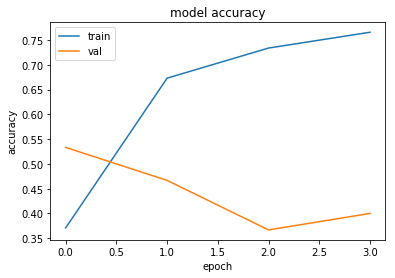

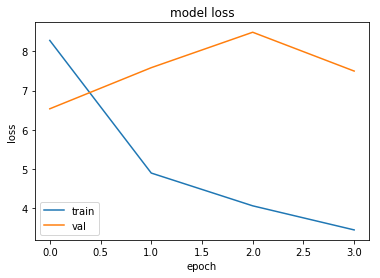

In [20]:
plot_train_val_acc(ffhistory)
plot_train_val_loss(ffhistory)

In [ ]:
def cnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[:20]
    y_val = y_train[:20]
    X_train_true = X_train[20:]
    y_train_true = y_train[20:]
    
    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(64, 1077, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=64, validation_data=(X_val, y_val), 
              callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
cnnmodel, cnnhistory = cnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
                      y_test)

In [ ]:
plot_train_val_acc(cnnhistory)
plot_train_val_loss(cnnhistory)

In [ ]:
def rnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[-50:]
    y_val = y_train[-50:]
    X_train_true = X_train[:-50]
    y_train_true = y_train[:-50]
    
    print(X_train.shape)
    print(X_train_true.shape)
    print(X_val.shape)
    
    model = Sequential()
    model.add(GRU(16, input_shape=(64, 1077), recurrent_dropout=0.3, return_sequences=True))
    model.add(GRU(32, input_shape=(64, 1077), recurrent_dropout=0.3))
#     model.add(LSTM(256, recurrent_dropout=0.5, return_sequences=True))
#     model.add(LSTM(512, recurrent_dropout=0.5))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=512, validation_data=(X_val, y_val), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [ ]:
rnnmodel, rnnhistory = rnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2]), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2]), 
                      y_test)

In [ ]:
plot_train_val_acc(rnnhistory)
plot_train_val_loss(rnnhistory)

# Trying out random baseline traditional algos

## Unsupervised

## Gausian HMM

In [ ]:
def hmm_model(accents, lengths):
    models = []
    for i, accent in enumerate(accents):
        np_accent = np.array(accent)
        np_accent = np_accent.reshape(np_accent.shape[0], np_accent.shape[1] * np_accent.shape[2])
        print(np_accent.shape)
        model = hmm.GaussianHMM(n_components=1, covariance_type='diag').fit(np_accent, [40 for _ in range(lengths[i])])
        models.append(model)
    return models

In [ ]:
print(np.argmax(y_train, axis=1)[np.argmax(y_train, axis=1) == 0].shape)
print(y_train.shape)
print(np.argmax(y_train, axis=1)[np.argmax(y_train, axis=1) == 0].shape[0] / y_train.shape[0])

In [ ]:
print(len(english_X))
print(len(spanish_X))
print(len(arabic_X))
print(len(mandarin_X))
print(len(french_X)) 
# [english_X[8:], spanish_X[8:], arabic_X[8:], mandarin_X[6:], french_X[6:], [92, 92, 92, 59, 57]
hmmmodels = hmm_model([english_X[8:], spanish_X[8:], arabic_X[8:], mandarin_X[6:], french_X[6:]], [92, 92, 92, 59, 57])

In [ ]:
def predict_hmm_accuracy(accents_test, hmm_models, ground_truth):
    accuracy = 0
    for i, accent in enumerate(accents_test):
        max_score = [float("-inf")]
        prediction = -1
        accent = accent.reshape(1, accent.shape[0] * accent.shape[1])
        print(accent.shape)
        for j, model in enumerate(hmm_models):
            score = model.score(accent)
            if score > max_score:
                max_score = score
                prediction = j
        if prediction == ground_truth[i]:
            print('right')
            accuracy += 1
        else:
            print('wrong')
    accuracy /= len(ground_truth)
    print('accuracy = ' + str(accuracy))
    return accuracy

In [ ]:
print(english_X[0].shape)
hmmmodels[0].score(english_X[0].reshape(english_X[0].shape[0], english_X[0].shape[1]))

In [ ]:
ground_truth = [0 for _ in range(8)] + [1 for _ in range(8)] + [2 for _ in range(8)] + [3 for _ in range(6)] + [4 for _ in range(6)]
hmm_acc = predict_hmm_accuracy(english_X[:8] + spanish_X[:8] + arabic_X[:8] + mandarin_X[:6] + french_X[:6],
                              hmmmodels, ground_truth)